In [1]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt


# --- 1. Charger les couches ---


In [2]:
sushi = gpd.read_file("../data/SUSHII_2013_2022/SUHII_2013_2022_ilots_diffusion.shp")
vul_clim = gpd.read_file("../data/Vulnérabilité_Changements_Climatiques_2022.geojson")
veg = gpd.read_file("../data/Taux_de_végétalisation.geojson")


/opt/miniconda3/envs/mlcomp/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'nan.000000000000000' of field SUHII_2013_2022_ilots_diffusion.SUH19_13 parsed incompletely to real 0.
  return ogr_read(
/opt/miniconda3/envs/mlcomp/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'nan.000000000000000' of field SUHII_2013_2022_ilots_diffusion.vSUH19 parsed incompletely to real 0.
  return ogr_read(


In [3]:
# Vérifie les colonnes et les 3 premières lignes de chaque GeoDataFrame

for name, gdf in {
    "SUSHI": sushi,
    "Vulnérabilité climatique": vul_clim,
    "Végétation": veg
}.items():
    print(f"\n=== {name} ===")
    print("Colonnes :", list(gdf.columns))
    print("Aperçu :")
    print(gdf.head(3))
    print("-" * 60)



=== SUSHI ===
Colonnes : ['ID', 'IDIDU', 'SUH19_13', 'SUH19_22', 'vSUH19', 'geometry']
Aperçu :
    ID        IDIDU  SUH19_13  SUH19_22      vSUH19  \
0  1.0  24350032002  0.005679  0.005310   93.489612   
1  2.0  24350032003  0.004427  0.005257  118.743964   
2  3.0  24350032013  0.006513  0.005932   91.077037   

                                            geometry  
0  POLYGON ((-302349.861 323130.289, -302363.352 ...  
1  POLYGON ((-303632.211 322179.839, -303754.019 ...  
2  POLYGON ((-304216.769 320642.949, -304229.597 ...  
------------------------------------------------------------

=== Vulnérabilité climatique ===
Colonnes : ['FID', 'PageName', 'PageNumber', 'ChaleurCl', 'SecheresCl', 'TempeteCl', 'PluiesCl', 'CruesCl', 'ChaleurCat', 'PluiesCat', 'SechereCat', 'CruesCat', 'TempeteCat', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']
Aperçu :
   FID PageName  PageNumber  ChaleurCl  SecheresCl  TempeteCl  PluiesCl  \
0    0    S1574         489          1           1          1       

# Decoupage

CRS : EPSG:32188
Nombre de polygones : 34
Colonnes : ['CODEID', 'NOM', 'NOM_OFFICI', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV', 'TYPE', 'COMMENT', 'DATEMODIF', 'geometry']


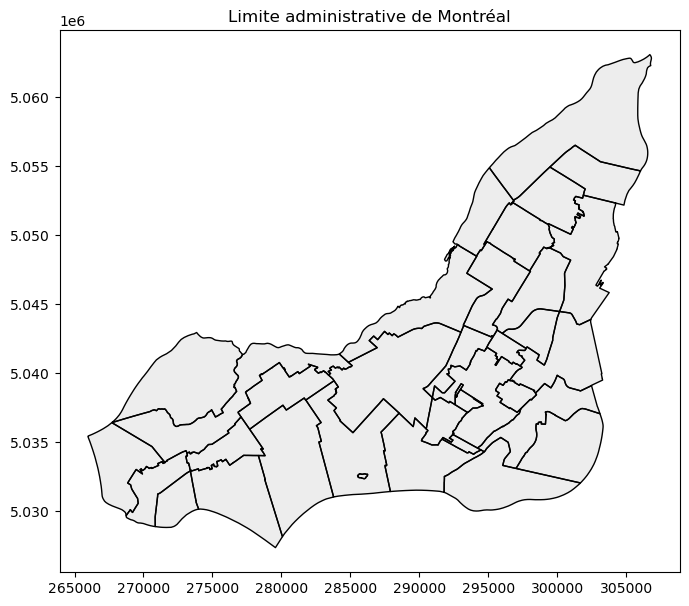

In [4]:
# --- 1. Charger la limite ---
limite_mtl = gpd.read_file("../data/Limites-administratives-agglomération/limites-administratives-agglomeration-nad83.shp")

# --- 2. Vérifier le système de coordonnées ---
print("CRS :", limite_mtl.crs)
print("Nombre de polygones :", len(limite_mtl))
print("Colonnes :", list(limite_mtl.columns))

# --- 3. Afficher la carte ---
fig, ax = plt.subplots(figsize=(8, 8))
limite_mtl.boundary.plot(ax=ax, color="black", linewidth=1)
limite_mtl.plot(ax=ax, color="lightgrey", alpha=0.4)
ax.set_title("Limite administrative de Montréal")
plt.show()

In [5]:
print("SUSHI géométries valides :", sushi.is_valid.all())
print("Vulnérabilité géométries valides :", vul_clim.is_valid.all())
print("Végétation géométries valides :", veg.is_valid.all())
print("Limite Montréal valide :", limite_mtl.is_valid.all())


SUSHI géométries valides : True
Vulnérabilité géométries valides : True
Végétation géométries valides : False
Limite Montréal valide : True


In [6]:
from shapely import make_valid

# Corriger uniquement la couche végétation
veg["geometry"] = veg["geometry"].apply(make_valid)

# (ou, si make_valid n’existe pas dans ta version de shapely)
# veg["geometry"] = veg.buffer(0)

# Vérifier
print("SUSHI géométries valides :")
print(sushi.is_valid.all())
print("Vulnérabilité géométries valides :")
print(vul_clim.is_valid.all())
print("Végétation géométries valides :")
print(veg.is_valid.all())
print("Limite Montréal valide :")
print(limite_mtl.is_valid.all())


SUSHI géométries valides :
True
Vulnérabilité géométries valides :
True
Végétation géométries valides :
True
Limite Montréal valide :
True


In [7]:

# --- 1. Harmoniser CRS ---
limite_mtl = limite_mtl.to_crs("EPSG:4326")

for gdf in [sushi, vul_clim, veg]:
    gdf.to_crs("EPSG:4326", inplace=True)

# --- 2. Découper chaque couche à la limite ---
sushi_mtl = gpd.clip(sushi, limite_mtl)
vul_clim_mtl = gpd.clip(vul_clim, limite_mtl)
veg_mtl = gpd.clip(veg, limite_mtl)

# --- 4. Vérification rapide ---
print("SUSHI Montréal :", len(sushi_mtl))
print("Vulnérabilité Montréal :", len(vul_clim_mtl))
print("Végétation Montréal :", len(veg_mtl))

#visualisation rapide
fig, ax = plt.subplots(figsize=(10, 8))

sushi_mtl.plot(ax=ax, color='red', alpha=0.5, label='Sushis')
vul_clim_mtl.plot(ax=ax, color='blue', alpha=0.5, label='Vulnérabilité climatique')
veg_mtl.plot(ax=ax, color='green', alpha=0.5, label='Végétation')

ax.set_title("Données climatiques - Montréal")
ax.legend()
plt.show()



KeyboardInterrupt: 

# Fusionner les données

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Vulnérabilité moyenne par maille SUSHI ---
vul_sushi = gpd.sjoin(vul_clim_mtl, sushi_mtl, how="inner", predicate="intersects")
vul_sushi = vul_sushi.groupby("ID").agg({
    "ChaleurCl": "mean",
    "PluiesCl": "mean"
}).reset_index()

# --- 2. Végétation moyenne par maille SUSHI ---
veg_sushi = gpd.sjoin(veg_mtl, sushi_mtl, how="inner", predicate="intersects")
veg_sushi = veg_sushi.groupby("ID").agg({
    "Veg_Taux": "mean"
}).reset_index()

# --- 3. Fusionner les moyennes sur la couche SUSHI ---
fusion = sushi_mtl.merge(vul_sushi, on="ID", how="left").merge(veg_sushi, on="ID", how="left")

print("Taille fusion finale (agrégée) :", len(fusion))

# --- 4. Calcul des indices normalisés ---
fusion["indice_sushi"] = (fusion["vSUH19"] - fusion["vSUH19"].min()) / (
    fusion["vSUH19"].max() - fusion["vSUH19"].min()
)
fusion["indice_chaleur"] = (fusion["ChaleurCl"] - fusion["ChaleurCl"].min()) / (
    fusion["ChaleurCl"].max() - fusion["ChaleurCl"].min()
)
fusion["indice_pluie"] = (fusion["PluiesCl"] - fusion["PluiesCl"].min()) / (
    fusion["PluiesCl"].max() - fusion["PluiesCl"].min()
)
fusion["indice_veg"] = 1 - (fusion["Veg_Taux"] / fusion["Veg_Taux"].max())  # plus vert = moins vulnérable

# --- 5. Indice global pondéré ---
fusion["indice_global"] = (
    0.4 * fusion["indice_sushi"] +
    0.3 * fusion["indice_chaleur"] +
    0.2 * fusion["indice_pluie"] +
    0.1 * fusion["indice_veg"]
)

# --- 6. Nettoyage final ---
fusion = fusion[[
    "ID",
    "indice_sushi",
    "indice_chaleur",
    "indice_pluie",
    "indice_veg",
    "indice_global",
    "geometry"
]]

# --- 7. Sauvegarde ---
fusion.to_file("../outputs/indice_climatique_global_montreal.gpkg", driver="GPKG")
print("✅ Fusion terminée et sauvegardée sous indice_climatique_global_montreal.gpkg")

# --- 8. Visualisation rapide ---
fig, ax = plt.subplots(figsize=(10, 8))
fusion.plot(
    ax=ax,
    column="indice_global",
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={'label': "Indice climatique global (0 = faible, 1 = élevé)"}
)
ax.set_title("Indice global de vulnérabilité climatique — Montréal", fontsize=13)
ax.axis("off")
plt.show()


In [ ]:
# --- Sauvegarde principale ---
output_dir = "../outputs"
fusion_path = f"{output_dir}/indice_climatique_global_montreal.gpkg"

fusion.to_file(fusion_path, driver="GPKG")
print(f"✅ Fichier principal sauvegardé : {fusion_path}")

# --- Sauvegarde des sous-indices séparés (optionnel pour réutilisation) ---
fusion[["ID", "indice_sushi", "geometry"]].to_file(f"{output_dir}/indice_sushi.gpkg", driver="GPKG")
fusion[["ID", "indice_chaleur", "geometry"]].to_file(f"{output_dir}/indice_chaleur.gpkg", driver="GPKG")
fusion[["ID", "indice_pluie", "geometry"]].to_file(f"{output_dir}/indice_pluie.gpkg", driver="GPKG")
fusion[["ID", "indice_veg", "geometry"]].to_file(f"{output_dir}/indice_vegetation.gpkg", driver="GPKG")

print("✅ Tous les fichiers ont été sauvegardés dans le dossier /outputs")
